<a href="https://colab.research.google.com/github/simon-clematide/casdmit-fs21/blob/master/notebooks/fasttext_we_de.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Word Embeddings with fasttext
Our tab-separated German text corpus:

Download the precomputed file if needed

In [ ]:
! wget https://files.ifi.uzh.ch/cl/siclemat/lehre/hs19/tm/parlament_transcriptions_tokenized_de.tsv -O parlament_transcriptions_tokenized_de.tsv

In [ ]:
! ls -lh parlament_transcriptions_tokenized_de.tsv
! tail -n 1 parlament_transcriptions_tokenized_de.tsv

## Building word embeddings with fasttext

In [1]:
! pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227140 sha256=d8762c689bb55ecc4ac9852398f5f3e7a6b7cf2400452e331985c9b35aafd278
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
! cut -f 3 parlament_transcriptions_tokenized_de.tsv > parlament_transcriptions_tokenized_de.txt

cut: parlament_transcriptions_tokenized_de.tsv: No such file or directory


That's pretty large. Takes about 2 hours on a 1 CPU binder VM, but several minutes on a modern multicore.

In [ ]:
import fasttext
model = fasttext.train_unsupervised('parlament_transcriptions_tokenized_de.txt', minCount=3, dim=100, epoch=10)
model.save_model('de.fasttext.bin')
print("Done")

We can also just download a prebuilt model instead of waiting.

In [2]:
! wget https://files.ifi.uzh.ch/cl/siclemat/lehre/hs19/tm/de.fasttext.bin -O de.fasttext.bin

--2024-05-02 22:10:14--  https://files.ifi.uzh.ch/cl/siclemat/lehre/hs19/tm/de.fasttext.bin
Resolving files.ifi.uzh.ch (files.ifi.uzh.ch)... 130.60.194.232
Connecting to files.ifi.uzh.ch (files.ifi.uzh.ch)|130.60.194.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 928782979 (886M) [application/octet-stream]
Saving to: ‘de.fasttext.bin’

de.fasttext.bin     100%[===================>] 885.76M  26.8MB/s    in 33s     

2024-05-02 22:10:48 (26.5 MB/s) - ‘de.fasttext.bin’ saved [928782979/928782979]



In [3]:
import fasttext
model = fasttext.load_model('de.fasttext.bin')

In [4]:
model.words[0::100]  # print every 100th word

[',',
 'weil',
 'sollen',
 'anliegen',
 'seiner',
 'sur',
 'weise',
 'verordnung',
 'vorhanden',
 'vorgeschlagen',
 'getan',
 'hinter',
 'vertrag',
 'rückweisung',
 'oktober',
 'entgegen',
 'rechnen',
 'walter',
 'beachten',
 'abschaffung',
 'wiederholen',
 'tiere',
 'ergebnisse',
 'swiss',
 'beziehungsweise',
 'aussicht',
 'zuständigkeit',
 'erarbeiten',
 'hinzuweisen',
 'tradition',
 'beschränkung',
 'liefern',
 'erhaltung',
 'einschränken',
 'zanetti',
 'lese',
 'irgendetwas',
 'nachtragskredit',
 'gebeten',
 'anhang',
 'ersuchen',
 'bulletins',
 'dieselben',
 'gewachsen',
 'wichtigkeit',
 'moderne',
 'minimale',
 'derselben',
 'bedeutend',
 'entfallen',
 'hearings',
 'verfolgung',
 'bafu',
 'präzise',
 'gegenzug',
 'konkretisiert',
 'seriöse',
 'meldungen',
 'wesentliches',
 'entfalten',
 'betreuen',
 'wozu',
 'papiere',
 'hausammann',
 'sachliche',
 'konsument',
 'standorten',
 'subventionieren',
 'drittes',
 'irgendeinem',
 'zivilprozessordnung',
 'eingeschlossen',
 'umsetzt',
 '

In [5]:
model["partei"]

array([ 0.2103933 , -0.01251918, -0.23940362, -0.00258187,  0.05390127,
        0.07833525,  0.43376   ,  0.4070175 ,  0.5441287 ,  0.27585155,
       -0.17462496, -0.16581652, -0.56777936, -0.14352308, -0.55187005,
       -0.09975535, -0.10994262, -0.60987186, -0.4215043 , -0.44066525,
        0.04292201, -0.10965731, -0.07449441,  0.30024892, -0.2529707 ,
        0.0221169 ,  0.26639217, -0.09456145, -0.5242377 , -0.5818027 ,
        0.6098762 ,  0.28402707, -0.31175396,  0.10572568,  0.1533342 ,
        0.36453024,  0.45768678, -0.10361389, -0.15458179, -0.25822553,
       -0.24256897, -0.14838515, -0.6107742 ,  0.15097138,  0.43741652,
        0.16479158,  0.33189827,  0.0256524 , -0.5258942 ,  0.17734095,
        0.5262596 ,  0.325477  , -0.06869166, -0.47827396,  0.30501184,
       -0.07776031, -0.3632174 , -0.50932777,  0.14439987,  0.37567598,
        0.39690617,  0.02270695, -0.3646591 ,  0.55625   ,  0.5411657 ,
        0.18801795, -0.5408855 ,  0.11819842, -0.02287341,  0.47

In [6]:
model.get_nearest_neighbors('verkehr',20)

[(0.8228897452354431, 'verkehrs'),
 (0.8162487745285034, 'schnellverkehr'),
 (0.8111129403114319, 'schienenverkehr'),
 (0.8103683590888977, 'quellverkehr'),
 (0.7945679426193237, 'zugverkehr'),
 (0.7855638861656189, 'lokalverkehr'),
 (0.7806897163391113, 'individualverkehr'),
 (0.7783641219139099, 'nahverkehr'),
 (0.7743416428565979, 'privatverkehr'),
 (0.7739962935447693, 'autoverkehr'),
 (0.7707362174987793, 'mailverkehr'),
 (0.7693454027175903, 'pw-verkehr'),
 (0.7662354707717896, 'verkehrsmitteln'),
 (0.7643353939056396, 'verkehre'),
 (0.7641147971153259, 'agglo-verkehr'),
 (0.763908326625824, 'busverkehr'),
 (0.7620394825935364, 'gesamtverkehr'),
 (0.7591068744659424, 'langsamverkehr'),
 (0.7550893425941467, 'motorisiertem'),
 (0.7545706033706665, 's-verkehr')]

A is to B, like ? is to C
`model.get_analogies(A,B,C)`

In [7]:
model.get_analogies("bundesrat","mann","frau")

[(0.6854112148284912, 'leuthard'),
 (0.6686673760414124, 'bundesrätin'),
 (0.6640538573265076, 'bundespräsidentin'),
 (0.6468939781188965, 'bundespräsident'),
 (0.6097736358642578, 'berset'),
 (0.6095626354217529, 'widmer-schlumpf'),
 (0.6048701405525208, 'herr'),
 (0.6042777895927429, 'gesamtbundesrat'),
 (0.6034507155418396, 'sommaruga'),
 (0.599902331829071, 'ständerätin')]

## Visualization

In [8]:
! pip install numpy scikit-learn matplotlib


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import fasttext

def visualize_words_2d(model, words):

    # Get the word embeddings
    embeddings = [model.get_word_vector(word) for word in words]

    # Apply PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)

    # Create a 2D scatter plot
    plt.figure(figsize=(10, 6))

    # Scatter plot of word embeddings
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

    # Annotate each point with its corresponding word
    for i, word in enumerate(words):
        plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], word, fontsize=12)

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Word Embeddings Visualization')
    plt.show()



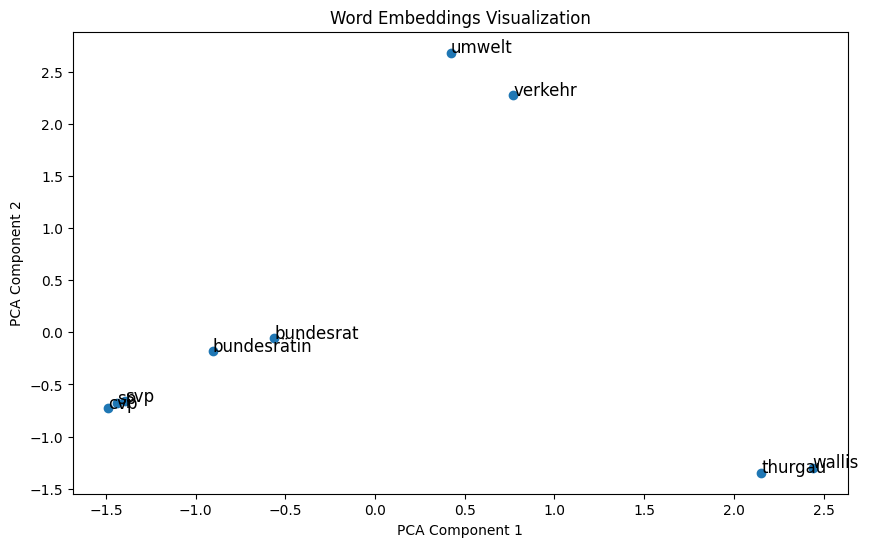

In [18]:

# Example usage:
visualize_words_2d(model, ['bundesrat','bundesrätin','verkehr','umwelt','svp','sp','cvp','thurgau','wallis'])